# Explicabilidade

In [223]:
#############################################################################################################
##### Notebook Explainability
##### Baseado em:
##  Dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
##
##############################################################################################################
## Objetivos:
##   Demonstrar os principais metodos de explainability

In [224]:
import pandas as pd
import numpy as np
import imblearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from interpret.blackbox import LimeTabular
from interpret import show

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import shap
import dice_ml

## Importação dos Dados

In [225]:
df = pd.read_csv('..\Datasets\diabetes.csv')
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Pré-processamento

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [227]:
# Observamos que algumas colunas possuem valores 0, quando não podem ter
# Como temos um valor pequeno de instâncias, vamos trata-los

cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[cols] = df[cols].replace(0, np.nan)
df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [228]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [229]:
# Substuições de valores mais simples, a partir da mediana
df['Glucose'] = df['Glucose'].fillna(df['Glucose'].median())
df['BloodPressure'] = df['BloodPressure'].fillna(df['BloodPressure'].median())
df['BMI'] = df['BMI'].fillna(df['BMI'].median())

In [230]:
# SkinThickness é um valor que indica a espessura da pele indicando a quantidade de gordura 
# subcutânea, contudo, como possui muitos valores nulos, vou remover e buscar confiar no BMI.
df.drop(columns=['SkinThickness'], inplace=True) 

In [231]:
# Buscando recuperar o valor de Insulin
# Aplico o KNN somente na coluna Insulin
from sklearn.impute import KNNImputer

from sklearn.impute import KNNImputer

# features relevantes para a insulina
features_for_impute = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Insulin']

imputer = KNNImputer(n_neighbors=5)
df[features_for_impute] = imputer.fit_transform(df[features_for_impute])

In [232]:
df.describe()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,153.799479,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,98.351458,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,87.900000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,135.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,191.050000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Divisão de Treinamento e Teste

In [233]:
from sklearn.preprocessing import StandardScaler

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2025, stratify=y
)

In [234]:
def oversample(X_train, y_train):
    oversample = RandomOverSampler(sampling_strategy='minority')
    # Converte para numpy e oversample
    x_np = X_train.to_numpy()
    y_np = y_train.to_numpy()
    x_np, y_np = oversample.fit_resample(x_np, y_np)
    # Convert de volta para pandas
    x_over = pd.DataFrame(x_np, columns=X_train.columns)
    y_over = pd.Series(y_np, name=y_train.name)
    return x_over, y_over

In [235]:
from sklearn.linear_model import LogisticRegression

# Oversampling no conjunto de treino
X_train, y_train = oversample(X_train, y_train)

print(X_train.shape)
print(X_test.shape)

(800, 7)
(154, 7)


In [236]:
y_train.value_counts()

Outcome
0    400
1    400
Name: count, dtype: int64

## Treinamento do Modelo

In [237]:
# %% Treinando o modelo blackbox
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

F1 Score 0.7266953110405381
Accuracy 0.7532467532467533


### Aplicaçãõ do LIME
Gera uma aproximação linear simples da decisão do modelo, para que possamos entender quais features mais influenciaram a previsão.

O modelo linear local indica que Glucose é a principal responsável pela previsão positiva

In [238]:
# Classificacao: predict_proba. Regressao: predict)
lime = LimeTabular(rf, 
                   X_train) # precisa do dataset para gerar as perturbacoes

# Retornar explanation
lime_local = lime.explain_local(X_test[-20:], 
                                y_test[-20:], 
                                name='LIME')
show(lime_local)

<!-- http://127.0.0.1:7250/1924592221920/ -->

### Aplicação do SHAP
Mede a contribuição de cada feature para a previsão de um modelo de machine learning.

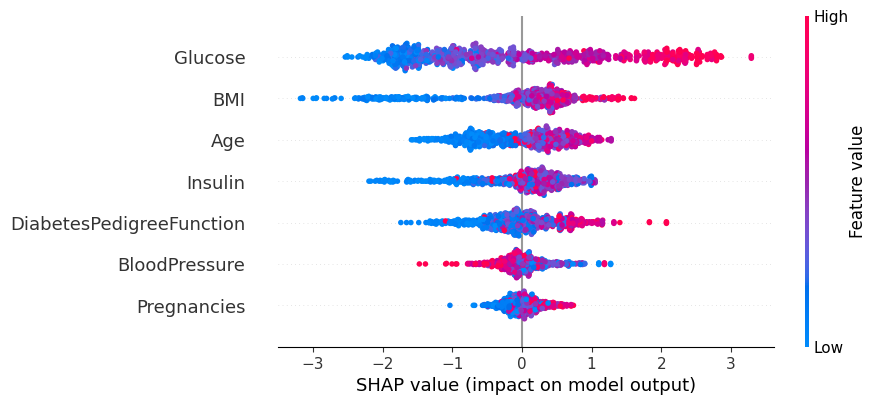

In [239]:
import xgboost

model = xgboost.XGBClassifier(n_estimators=20)
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

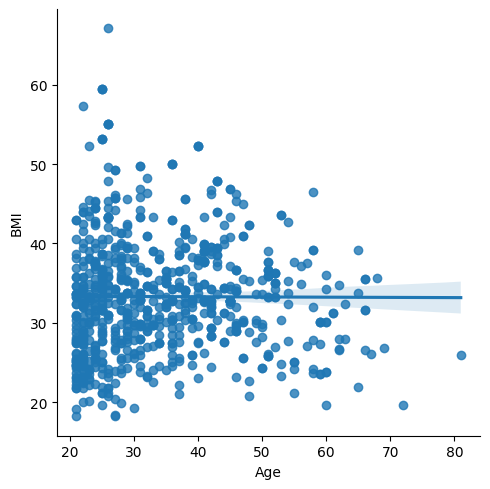

In [240]:
import seaborn as sns
sns.lmplot(x="Age", y="BMI", data=X_train)

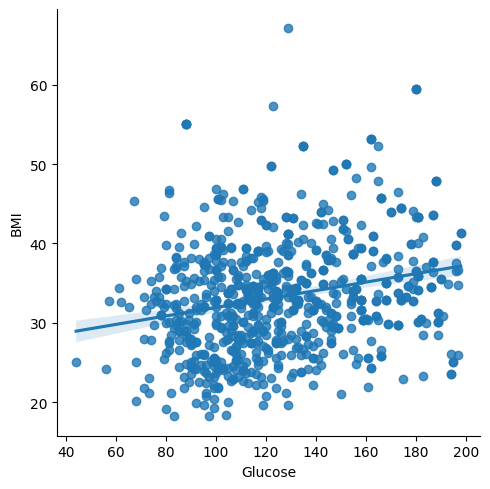

In [241]:
# Percebe-se que o KNN preencheu valores semelhantes, o que não é algo ideal
sns.lmplot(x="Glucose", y="BMI", data=X_train)

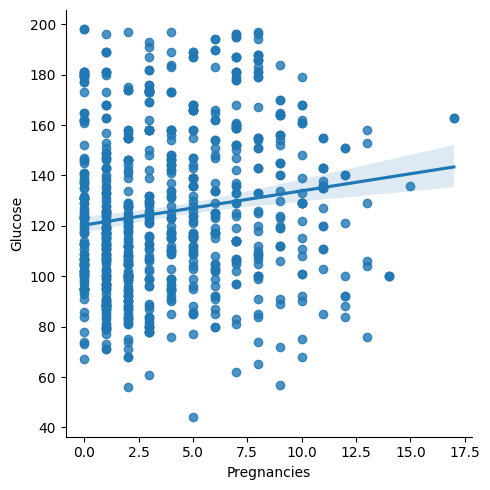

In [242]:
sns.lmplot(x="Pregnancies", y="Glucose", data=X_train)

In [243]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,4.00750,125.776250,72.751250,161.498500,33.292125,0.484762,33.962500
std,3.43871,31.624141,11.915299,104.855344,7.140452,0.333866,11.317186
min,0.00000,44.000000,24.000000,14.000000,18.200000,0.078000,21.000000
25%,1.00000,101.000000,65.750000,96.000000,28.300000,0.253750,25.000000
50%,3.00000,121.000000,72.000000,140.100000,32.900000,0.388500,31.000000
75%,6.00000,148.000000,80.000000,196.800000,37.400000,0.647000,41.000000
max,17.00000,198.000000,122.000000,846.000000,67.100000,2.420000,81.000000


### Aplicação do DiCE
Diverse Counterfactual Explanations
DiCE cria múltiplos contrafactuais diferentes, mostrando diversas possibilidades de mudança.

In [244]:
df.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,189.2,33.6,0.627,50.0,1
1,1.0,85.0,66.0,61.6,26.6,0.351,31.0,0
2,8.0,183.0,64.0,164.6,23.3,0.672,32.0,1
3,1.0,89.0,66.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,168.0,43.1,2.288,33.0,1


In [249]:
# Dataset
data_dice = dice_ml.Data(dataframe=df, 
                         # Indicar quem sao as caracteristicas continuas (para perturbacao)
                         continuous_features=X_train.columns.tolist(), 
                         outcome_name='Outcome')

In [246]:
# Modelo
rf_dice = dice_ml.Model(model=rf, 
                        backend="sklearn")
explainer = dice_ml.Dice(data_dice, 
                         rf_dice, 
                         method="random")

In [251]:
# %% Criar explanations
input_datapoint = X_test[0:1]
cf = explainer.generate_counterfactuals(input_datapoint, 
                                  total_CFs=3, 
                                  desired_class="opposite")

# Visualizar
cf.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5.0,139.0,64.0,140.0,28.6,0.411,26.0,1



Diverse Counterfactual set (new outcome: 0)


,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,-,77.8,-,-,-,74.7,0.0
1,7.3,77.1,-,-,-,-,-,0.0
2,-,-,94.8,-,-,-,-,0.0


In [248]:
# %% Criar contrafatos condicionais
features_to_vary=['Glucose',
                  'BMI',
                  'BloodPressure',
                  'Insulin']
permitted_range={'Glucose':[80,250],
                'BMI':[18, 35],
                'BloodPressure':[60, 90],
                'Insulin':[16, 166]}

cf = explainer.generate_counterfactuals(input_datapoint, 
                                  total_CFs=3, 
                                  desired_class="opposite",
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary)
# Visualizacao
cf.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5.0,139.0,64.0,140.0,28.6,0.411,26.0,1



Diverse Counterfactual set (new outcome: 0)


,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,112.6,-,-,-,-,-,0.0
1,-,101.1,-,40.5,-,-,-,0.0
2,-,-,-,-,22.6,-,-,0.0
